# Music Style Transfer through LSTM

Here we are attempting to see whether we can transfer the style of the music by changing the notes themselves. Here, our definition of style transfer has changed. We are interested in seeing whether a network can generate music by being "inspired" from another music.

To do this, we will first train a CNN that classifies music well. Then, we will use the actiavtions from one of the layers as a feature extractor and extract features from music. 

Next step is to use the features we extracted to generate the music back. This is done by conditioning a LSTM using the feature vector, and then train it to generate the music that was used to extract the feature vector. We will train 2 such generators.

Last step is to see whether the generators works as a translator. We will take one music from one class and extract the features. And then feed the feature into the other class to generate music. We will see if the network picks up the styles and whether the network can be "inspired" by the music

In [1]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
X = np.load('matricies/notes.npy')
Y = np.load('matricies/labels.npy')

In [5]:
X_small = np.load('matricies/small_notes.npy')
Y_small = np.load('matricies/small_Y.npy')

For this task we will toss the first dimension since it does not add additional information

In [6]:
X = X[:,:,:,1]
X_small = X_small[:,:,:,1]

# CNN encoding

In this section we first try to train a CNN that classifies music well. 

In [ ]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X, Y, test_size=0.1, random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

In [ ]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = X_input
    X = keras.layers.Conv1D(filters=4, kernel_size=32, padding='same', name='Conv0',
                            dilation_rate=4,
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.AveragePooling1D(4)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    
#     X = keras.layers.Reshape((250, -1))(X)
    X = keras.layers.Conv1D(filters=16, kernel_size=16, padding='valid', name='Conv1',
                            dilation_rate=2,
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.AveragePooling1D(2)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn1')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    X = keras.layers.Flatten()(X)
#     X = keras.layers.Dense(100, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(50, activation='sigmoid')(X)
    X = keras.layers.Dropout(0.5)(X)    
#     X = keras.layers.Dense(10, activation='sigmoid')(X)
    X = keras.layers.Dense(1, activation='sigmoid')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [ ]:
m = model1(X.shape[1:])
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
print(m.summary())

In [ ]:
m.fit(X_train, Y_train, epochs=4, batch_size=128)

In [ ]:
preds = m.evaluate(X_test, Y_test, batch_size=32)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
m.save('cnn.h5')

# Feature Extraction

Below is code for feature extraction.

In [8]:
m = keras.models.load_model('cnn.h5')

In [9]:
def extract_all_features(X, model, layer_nums, batch_num):
    """Extract all the features by taking out the activation output of the layers specified in layer_nums
    
        X : the data that we are trying to extract features from
        model: the model that we are using to extract the features
        layer_nums: the layer number that we want to use as feature extractors
    """
    outputs = [model.layers[layer].output for layer in layer_nums]
    f = keras.backend.function([model.input, keras.backend.learning_phase()], outputs)
    ## split up into smaller chunks
    layer_outs = []
    m = X.shape[0]
    for i in range(batch_num + 1):
        layer_outs += [f([X[(m // batch_num * i):(m // batch_num * (i+1)), :, :], 0.])]
    result = []
    for i in range(len(layer_nums)):
        layer_outs2 = []
        for batch in range(batch_num):
            activations = layer_outs[batch][i]
            activations = activations.reshape(activations.shape[0], -1)
            layer_outs2 += [activations]
        result += [np.vstack(np.array(layer_outs2))]
    return result

In [10]:
classical_features = extract_all_features(X_small[(Y_small == 1).ravel(), :, :], m, [9, 10], 160)
jazz_features = extract_all_features(X_small[(Y_small == 0).ravel(), :, :], m, [9, 10], 160)
np.savetxt('matricies/classical_features_big.txt', classical_features[0])
np.savetxt('matricies/jazz_features_big.txt', jazz_features[0])
np.savetxt('matricies/classical_features_small.txt', classical_features[1])
np.savetxt('matricies/jazz_features_small.txt', jazz_features[1])

## LSTM (RUN THIS SECTION)

Here we will train 2 (bidirectional) LSTMs. One for generating classical music and one for generating jazz music. The way we condition the LSTMs is to have a Dense layer that transforms our feature vectors into the shape of the cell state of the LSTM, and then we will use this cell state as the initial cell state of the LSTM, and train it to generate the original MIDI matrix. 

The input to the model is a feature vector. It will then have a dense layer that transforms it into the cell state shape. Then for every time stamp it will generate some music, and the output should be a music.

First we need to construct the new X and Ys. The X will be the same but with the last layer stacked on top of each other insead. Y will be the same as X but all values shifted left by 1 timestamp

In [7]:
classical_features_big = np.loadtxt('matricies/classical_features_big.txt')
jazz_features_big = np.loadtxt('matricies/jazz_features_big.txt')
classical_features_small = np.loadtxt('matricies/classical_features_small.txt')
jazz_features_small = np.loadtxt('matricies/jazz_features_small.txt')
classical_features = [classical_features_big, classical_features_small]
jazz_features = [jazz_features_big, jazz_features_small]

In [8]:
gen_T = 480
m_ckeep = classical_features[1].shape[0]
m_jkeep = jazz_features[1].shape[0]
X2_classical = X_small[(Y_small==1).ravel(), :,:][:m_ckeep,:gen_T,:]
X2_jazz = X_small[(Y_small==0).ravel(), :m_jkeep,:][:m_jkeep,:gen_T,:]

Y2_classical = np.zeros(X2_classical.shape, dtype=np.int32)
Y2_classical[:-1,:,:] = X2_classical[1:,:,:]
Y2_jazz = np.zeros(X2_jazz.shape, dtype=np.int32)
Y2_jazz[:-1,:,:] = X2_jazz[1:,:,:]

The following code is inspired and borrowed from Coursera Sequence Model Module/Improvise a Jazz Solo with an LSTM Network - v3 programming assignment

In [9]:
n_a = 64
n_values = 59
LSTM_cell = keras.layers.LSTM(n_a, return_state = True)
feature_densor = keras.layers.Dense(n_a, activation='sigmoid')
# on_off_densor = keras.layers.Dense(n_values, activation='sigmoid')
sustain_densor = keras.layers.Dense(n_values, activation='sigmoid')
reshapor = keras.layers.Reshape((1, n_values))
concatenator = keras.layers.Concatenate(axis=-1)

In [10]:
def lstm(feature_shape, Tx, n_channel):
    feature_input = keras.layers.Input(feature_shape, name='feature_inp')
    music_input = keras.layers.Input((Tx, n_channel), name='X')
    a0 = keras.layers.Input((n_a,), name='a0')
    
#     feature = keras.layers.Flatten()(feature_input)
    c0 = feature_densor(feature_input)
    X = music_input
    a = a0
    c = c0
    outputs = []
    for t in range(Tx):
        if t % 200 == 0:
            print(t)
        x = keras.layers.Lambda(lambda x: X[:, t, :])(X)
        x = reshapor(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
#         on_off_out = on_off_densor(a)
        sustain_out = sustain_densor(a)
#         outputs += [concatenator([on_off_out, sustain_out])]
        outputs += [sustain_out]
    return keras.models.Model(inputs=[feature_input, music_input, a0], outputs=outputs)
    
    

In [11]:
lstm_model = lstm((classical_features[1].shape[1], ), gen_T, X.shape[2])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

0
200
400


In [12]:
lstm_model.load_weights('lstm_classical_1.h55')

In [ ]:
%%capture
mini_size = X2_classical.shape[0]
a0 = np.zeros((mini_size, n_a))
lstm_model.fit([classical_features[1][:mini_size:,:], X2_classical[:mini_size,:,:], a0],
               list(Y2_classical[:mini_size,:,:].transpose((1, 0, 2))), epochs=1);

In [ ]:
lstm_model.save_weights('lstm_classical.h55')

### Generate Music with LSTM

Now we will sample the LSTM and densor we just trained to generate some cool music

In [94]:
def set_one_hot(x):
    random_tensor = tf.random_uniform(tf.shape(x), 0.01, 1.0)
    return tf.to_float(tf.greater(x, random_tensor))
one_hot = keras.layers.Lambda(set_one_hot)

In [95]:
def lstm_generate(LSTM_cell, sustain_densor, feature_shape, n_values, n_a, Ty=200):
    x0 = keras.layers.Input((1, n_values), name='x0')
    feature_input = keras.layers.Input(feature_shape, name='feature_inp')
    a0 = keras.layers.Input((n_a,), name='a0')
    
    c0 = feature_densor(feature_input)
    a = a0
    c = c0
    x = x0
    outputs = []
    for t in range(Ty):
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = sustain_densor(a)
        out = one_hot(out)
        out = reshapor(out)
        outputs += [out]
        x = out
    return keras.models.Model(inputs=[feature_input, x0, a0], outputs=outputs)

In [96]:
generate_model = lstm_generate(LSTM_cell, sustain_densor, (classical_features[1].shape[1],), n_values, n_a, Ty=160)

In [97]:
feature_input = jazz_features[1][6:7,:]
x0 = np.zeros((1, 1, n_values))
a0 = np.zeros((1, n_a,))
print(feature_input.shape, x0.shape,a0.shape)

(1, 50) (1, 1, 59) (1, 64)


In [98]:
pred = generate_model.predict([feature_input, x0, a0])

In [99]:
song = np.array(pred).reshape(-1, n_values)
# song = song > 0.5
print(song.shape)

(160, 59)


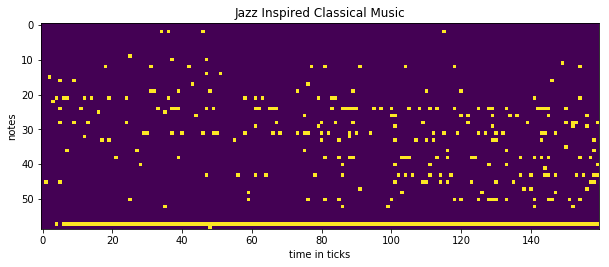

In [100]:
plt.figure(figsize=(10, 5))
plt.imshow(song.T)
plt.xlabel('time in ticks')
plt.ylabel('notes')
plt.title('Jazz Inspired Classical Music')
plt.savefig('plots/jazz_inspired_classical.png')

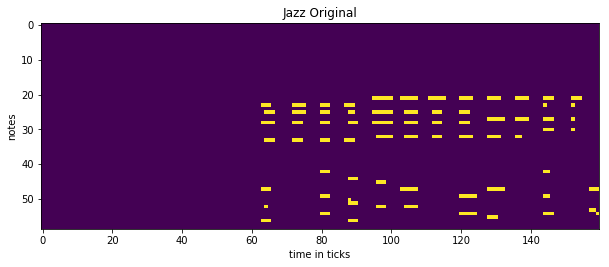

In [107]:
plt.figure(figsize=(10, 5))
plt.imshow(Y2_jazz[6, :160].T)
plt.xlabel('time in ticks')
plt.ylabel('notes')
plt.title('Jazz Original')
plt.savefig('plots/jazz_inspired_original.png')

In [42]:
X2_classical.shape

(320, 480, 59)

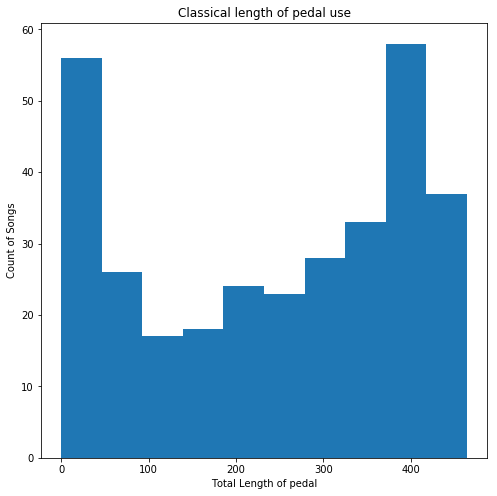

In [104]:
plt.figure(figsize=(8, 8))
plt.hist(np.sum(X2_classical[:,:,57], axis=-1))
plt.xlabel('Total Length of pedal')
plt.ylabel('Count of Songs')
plt.title('Classical length of pedal use')
plt.savefig('plots/classical_pedal.png')

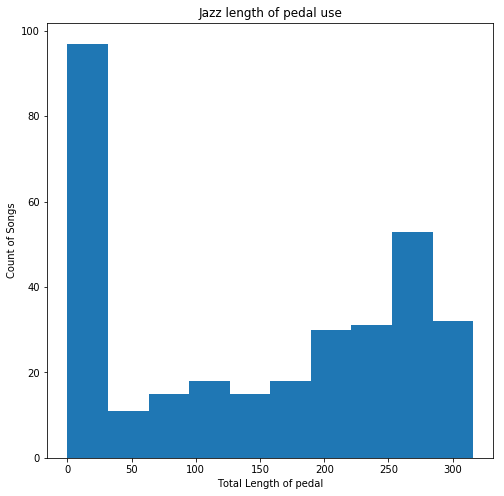

In [105]:
plt.figure(figsize=(8, 8))
plt.hist(np.sum(X2_jazz[:,:,57], axis=-1))
plt.xlabel('Total Length of pedal')
plt.ylabel('Count of Songs')
plt.title('Jazz length of pedal use')
plt.savefig('plots/jazz_pedal.png')

In [102]:
target_ticks_per_beat = 8
notes_to_keep_down = 32
def generate(sustain_mat, velocity_mat):
    new_midi = mido.MidiFile(type=0)
    new_midi.ticks_per_beat = target_ticks_per_beat
    track = mido.MidiTrack()
    new_midi.tracks.append(track)

    track.append(mido.MetaMessage('set_tempo', tempo=1000000, time=0))
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, 
                             clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

    T, N = sustain_mat.shape
    notes_on = [False] * N
    prev_event_t = 0
    for t in range(T):
        for n in range(N-2):
            if sustain_mat[t, n] > 0 and not notes_on[n]:
                velocity = velocity_mat[t, n]
                track.append(mido.Message('note_on', note=n+notes_to_keep_down, velocity=velocity, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = True
            if sustain_mat[t, n] == 0 and notes_on[n]:
                track.append(mido.Message('note_on', note=n+notes_to_keep_down, velocity=0, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = False
        if sustain_mat[t, N-2] == 1 and not notes_on[N-2]:
            track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = True
        if sustain_mat[t, N-1] == 1 and not notes_on[N-1]:
            track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-1] = True
        if notes_on[N-2] and sustain_mat[t, N-2] == 0:
            track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = False
        if notes_on[N-1] and sustain_mat[t, N-1] == 0:
            track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-1] = False
    return new_midi

In [103]:
# new_midi = generate((song > 0.02).reshape(200, 130,2) , np.ones(song.shape, dtype=np.int8) * 64, info)
# new_midi = X2_classical[100,:,:]
new_midi = song
new_midi = generate(new_midi, np.ones(new_midi.shape, dtype=np.int8) * 127)
# plt.imshow(new_midi)
new_midi.save('temp.midi')